In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from glob import glob
import seaborn as sns
from PIL import Image

In [75]:
np.random.seed(42)
# !pip install autokeras
# import autokeras as ak

import tensorflow as tf
import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

import itertools
from keras import backend as K
import itertools

# from keras.layers.normalization import BatchNormalization
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
)

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

## Load In the Data

In [3]:
skin_df = pd.read_csv("dataverse_files/HAM10000_metadata.csv")

In [4]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [5]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('dataverse_files/', '*', '*.jpg'))}

In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)

In [7]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))


In [8]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,dataverse_files\all_images\ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


In [9]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


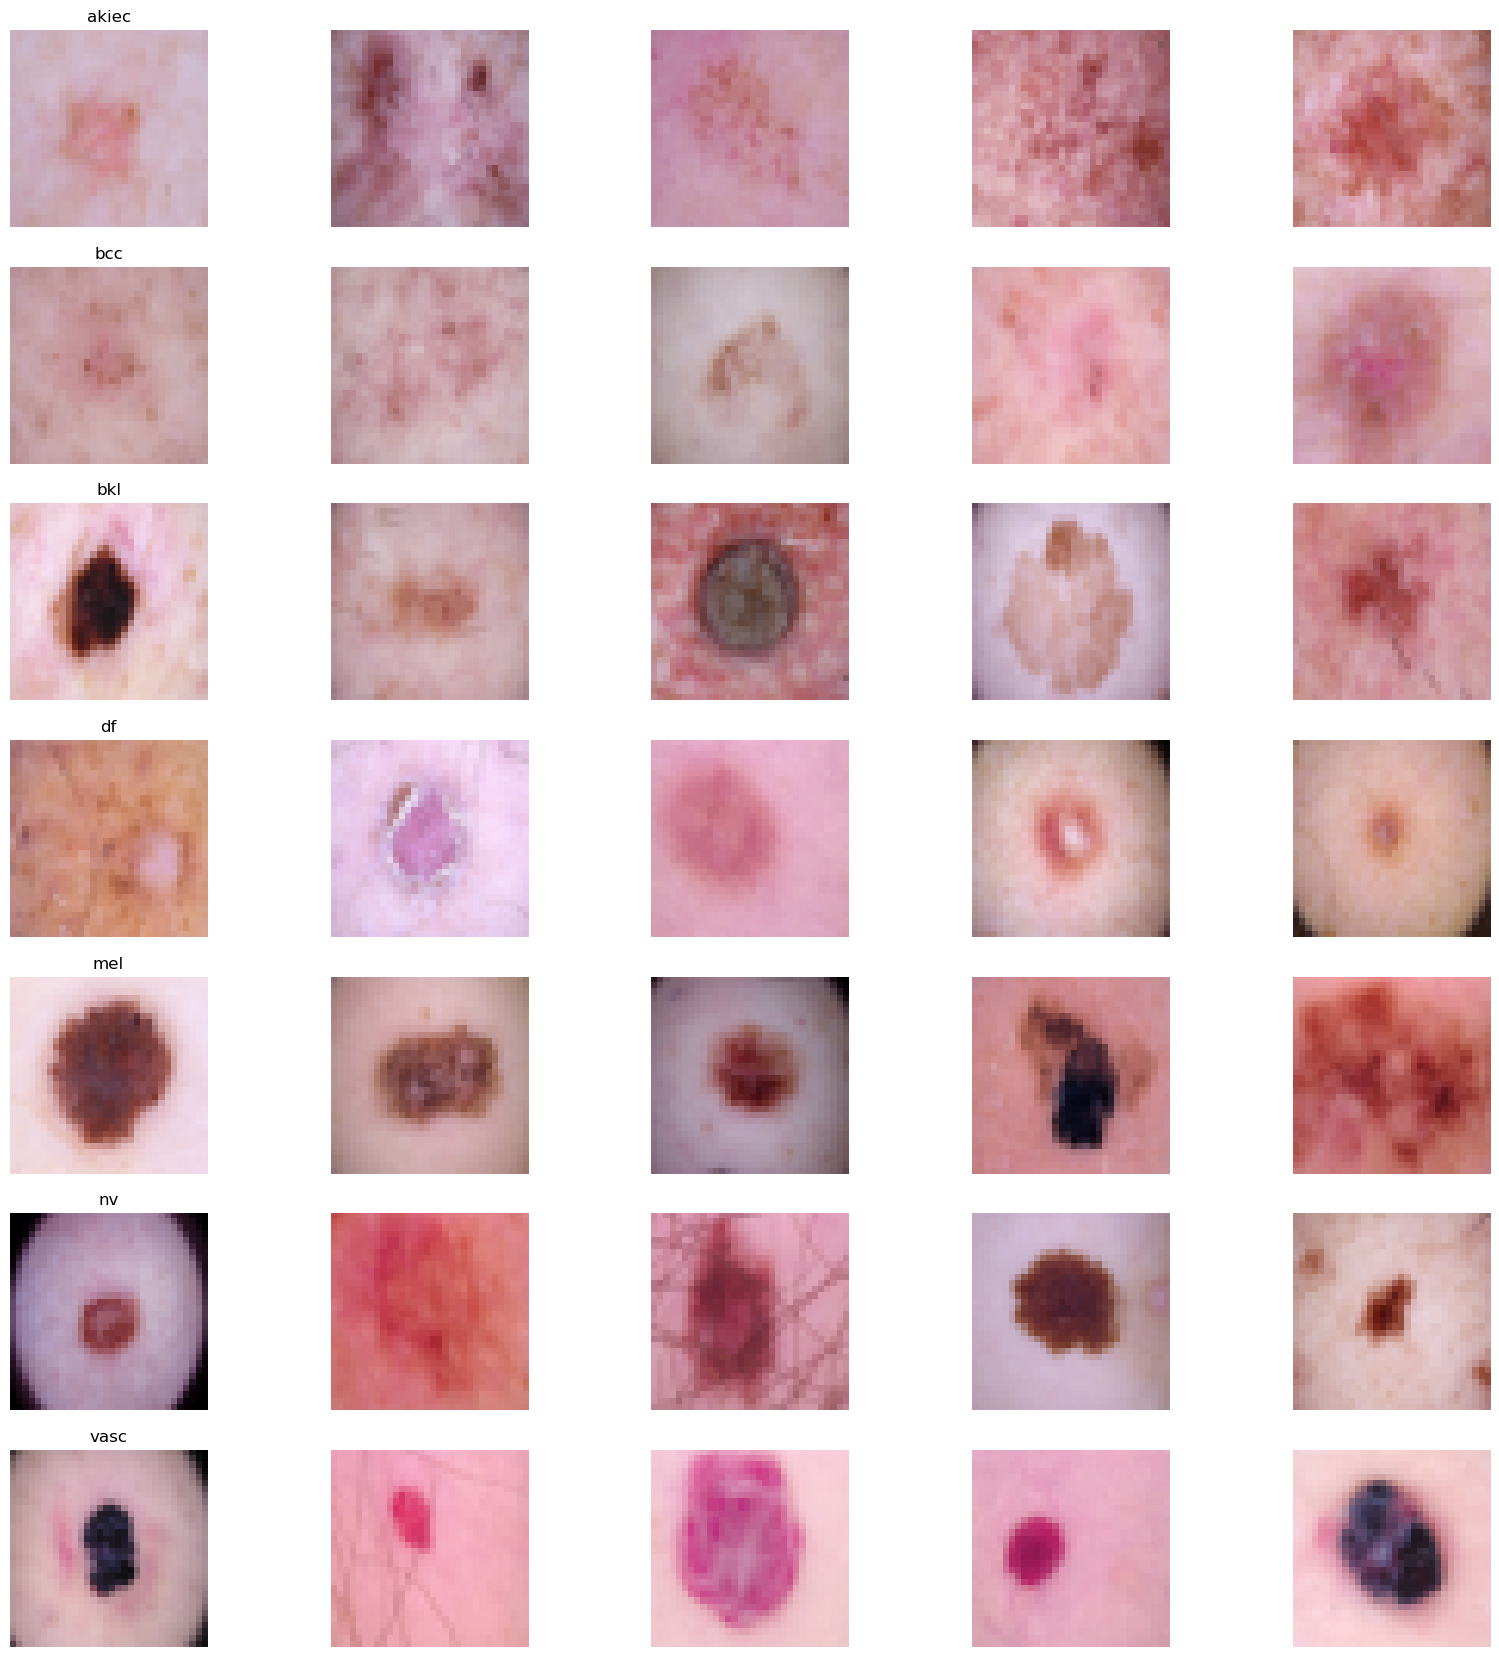

In [10]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [11]:
import shutil

In [12]:
data_dir = os.getcwd() + "/dataverse_files/all_images/"

In [13]:
dest_dir = os.getcwd() + "/dataverse_files/reorganized/"

In [14]:
skin_df2 = pd.read_csv('dataverse_files/HAM10000_metadata.csv')

In [15]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [16]:
label=skin_df2['dx'].unique().tolist()  #Extract labels into a list
label_images = []

In [17]:
print(label)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


In [18]:
for i in label:
    os.mkdir(dest_dir + str(i) + "/")
    sample = skin_df2[skin_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Anuragh Barua\\Downloads/dataverse_files/reorganized/bkl/'

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [20]:
#Define datagen. Here we can define any transformations we want to apply to images
datagen = ImageDataGenerator()

In [21]:
# define training directory that contains subfolders
train_dir = os.getcwd() + "/dataverse_files/reorganized/"

In [22]:
#Use flow_from_directory
train_data_keras = datagen.flow_from_directory(directory=train_dir,
                                         class_mode='categorical',
                                         batch_size=16,  #16 images at a time
                                         target_size=(32,32))  #Resize images

Found 10015 images belonging to 7 classes.


In [23]:
#We can check images for a single batch.
x, y = next(train_data_keras)

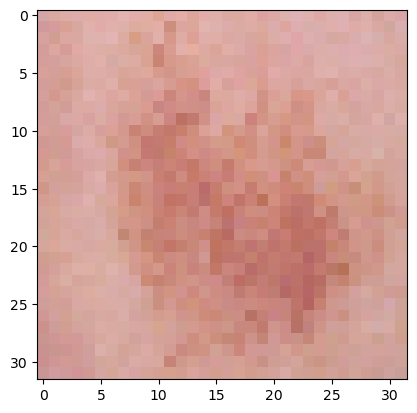

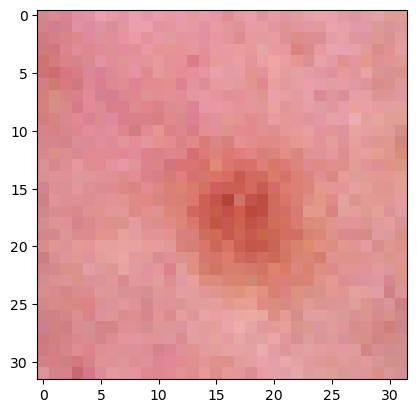

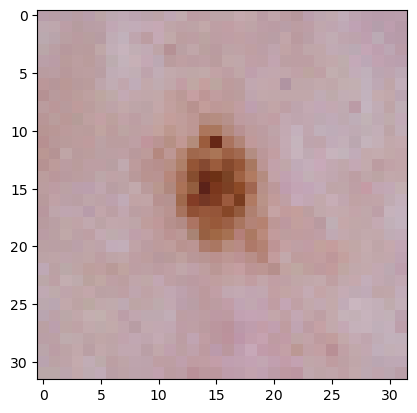

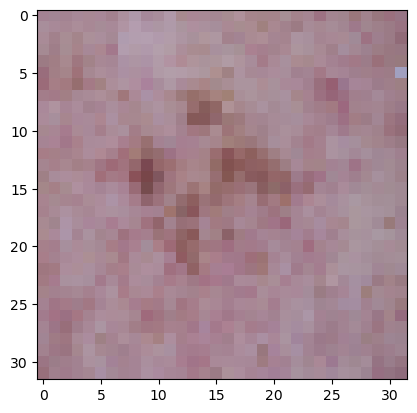

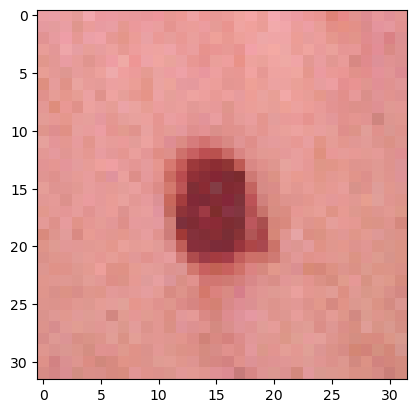

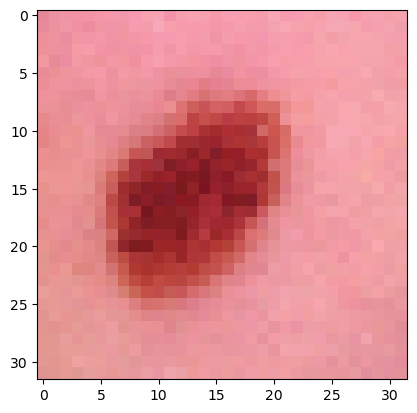

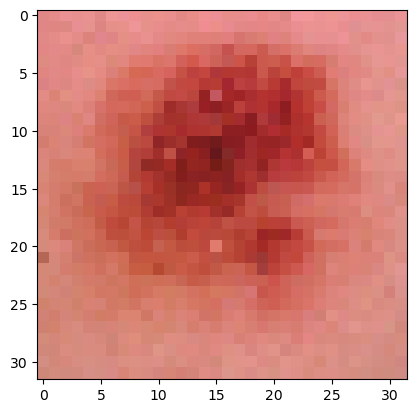

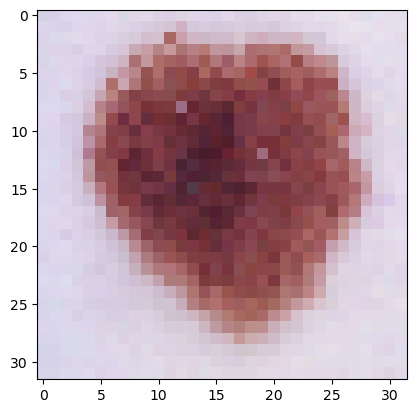

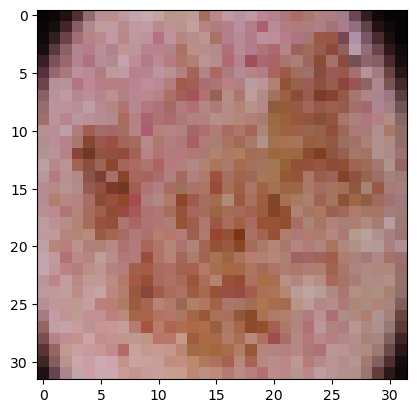

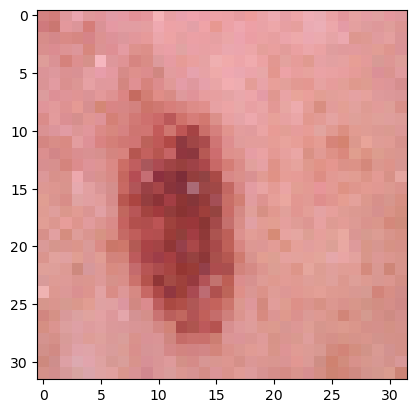

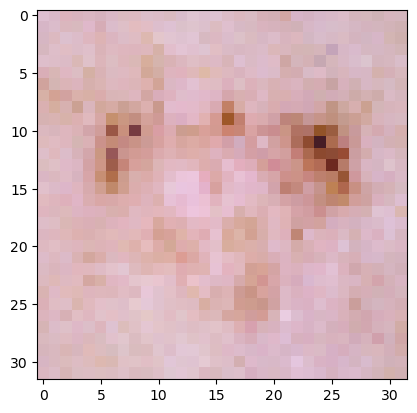

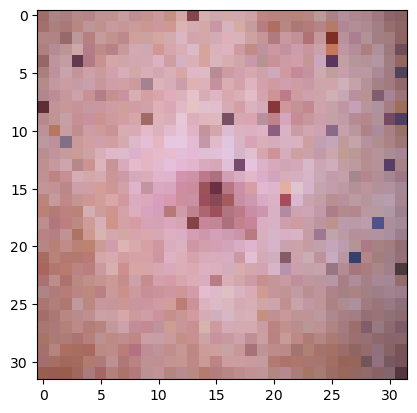

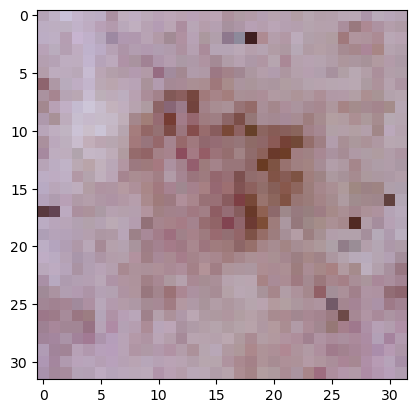

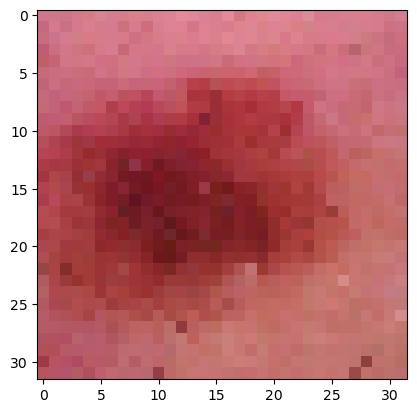

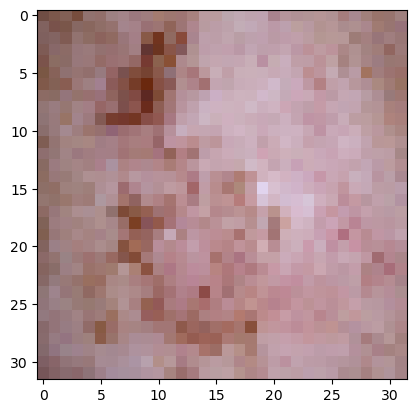

In [24]:
#View each image
for i in range (0,15):
    image = x[i].astype(int)
    plt.imshow(image)
    plt.show()

In [25]:
print(x)

[[[[211. 167. 166.]
   [218. 168. 159.]
   [221. 172. 167.]
   ...
   [212. 163. 156.]
   [220. 170. 169.]
   [216. 166. 167.]]

  [[208. 153. 156.]
   [214. 155. 157.]
   [217. 161. 148.]
   ...
   [217. 168. 163.]
   [209. 166. 157.]
   [216. 174. 175.]]

  [[213. 162. 159.]
   [208. 158. 147.]
   [220. 167. 161.]
   ...
   [214. 174. 172.]
   [216. 167. 160.]
   [216. 172. 169.]]

  ...

  [[201. 145. 144.]
   [200. 150. 143.]
   [204. 149. 146.]
   ...
   [211. 162. 155.]
   [210. 161. 157.]
   [207. 162. 156.]]

  [[203. 143. 143.]
   [206. 150. 149.]
   [211. 154. 147.]
   ...
   [207. 158. 151.]
   [205. 158. 152.]
   [205. 162. 153.]]

  [[200. 150. 149.]
   [210. 155. 160.]
   [206. 155. 154.]
   ...
   [200. 155. 149.]
   [206. 161. 156.]
   [199. 159. 151.]]]


 [[[208. 135. 144.]
   [218. 139. 144.]
   [219. 130. 148.]
   ...
   [225. 163. 166.]
   [224. 157. 149.]
   [224. 157. 151.]]

  [[210. 131. 137.]
   [212. 125. 144.]
   [212. 130. 144.]
   ...
   [218. 155. 150.]
 

In [26]:
SIZE = 32

In [27]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [28]:
skin_df['label'] = le.transform(skin_df["dx"])
skin_df.head()
# print(skin_df)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,dataverse_files\all_images\ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,dataverse_files\all_images\ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,...",2


C:\Users\Anuragh Barua\AppData\Local\Temp\ipykernel_11988\1848369455.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


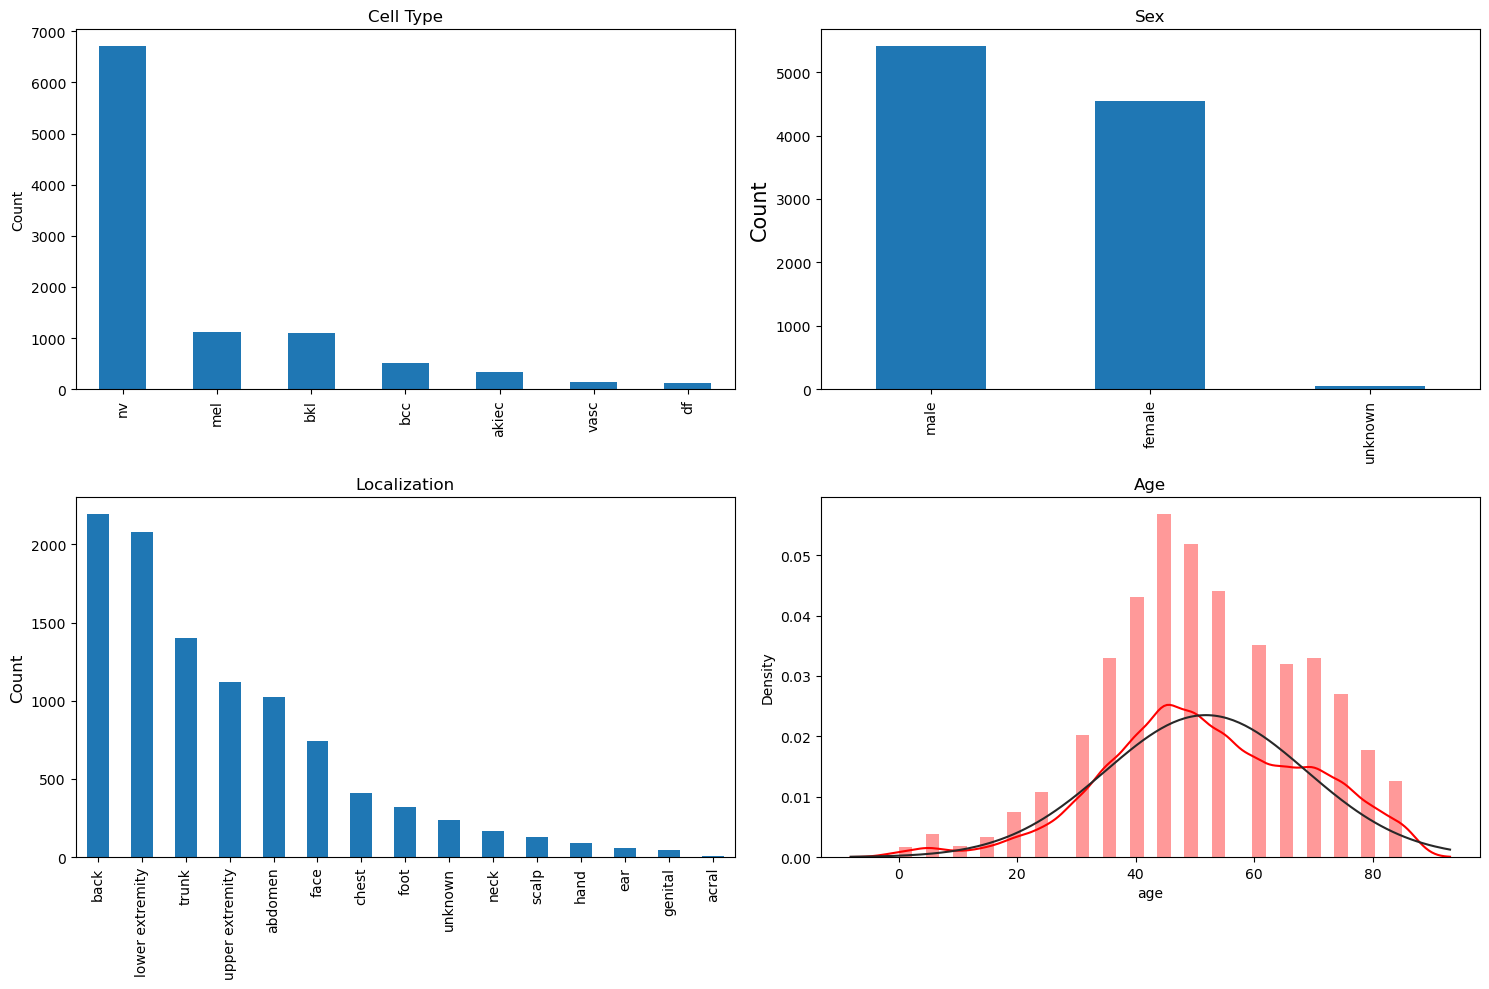

In [29]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [30]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())


5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [31]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [32]:
# Resamples the data into some number we want so to balance the dataset (Increase lower values to threshold and decrease others)
n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [33]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [34]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,image,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,rosendahl,dataverse_files\all_images\ISIC_0026645.jpg,"[[[155, 118, 107], [162, 126, 118], [174, 140,...",0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,rosendahl,dataverse_files\all_images\ISIC_0025780.jpg,"[[[138, 76, 82], [131, 64, 68], [139, 73, 81],...",0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,rosendahl,dataverse_files\all_images\ISIC_0024450.jpg,"[[[123, 86, 87], [174, 137, 137], [197, 161, 1...",0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,rosendahl,dataverse_files\all_images\ISIC_0027896.jpg,"[[[205, 149, 175], [207, 149, 169], [214, 158,...",0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,rosendahl,dataverse_files\all_images\ISIC_0029268.jpg,"[[[203, 174, 199], [205, 174, 197], [206, 175,...",0


In [35]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [36]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('dataverse_files/', '*', '*.jpg'))}

In [37]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)

In [38]:
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


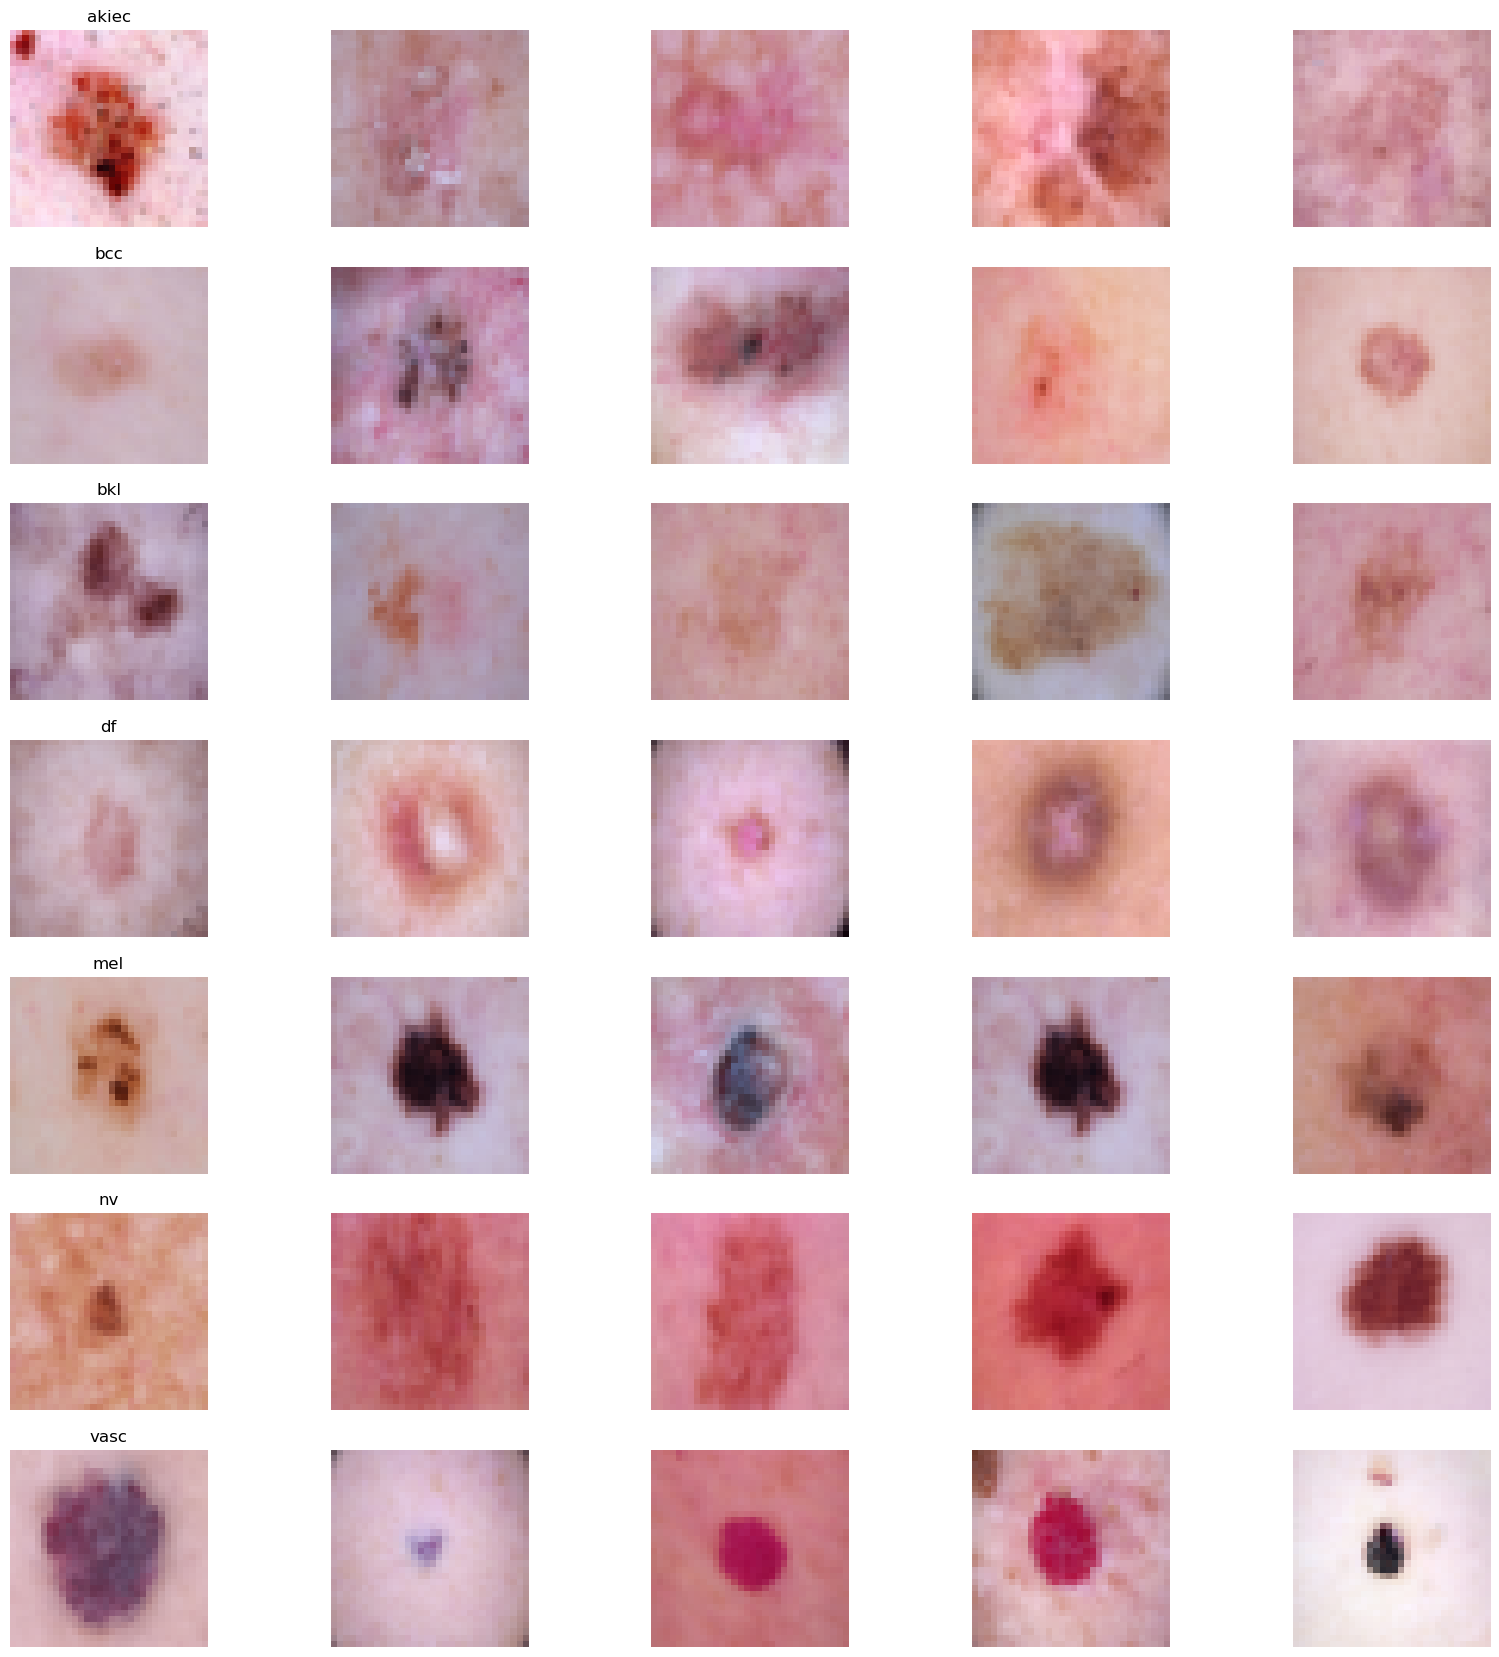

In [39]:
n_samples = 5 

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [89]:
# #Convert dataframe column of images into numpy array
# X = np.asarray(skin_df_balanced['image'].tolist())
# np.shape(X) #3500 images of size 32 x 32 with 3 axes

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df['image'].tolist())
np.shape(X) #3500 images of size 32 x 32 with 3 axes

(10015, 32, 32, 3)

In [90]:
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
X

array([[[[0.74901961, 0.59607843, 0.75294118],
         [0.76078431, 0.60392157, 0.75686275],
         [0.76862745, 0.59607843, 0.72156863],
         ...,
         [0.76470588, 0.58431373, 0.62352941],
         [0.77254902, 0.60784314, 0.64313725],
         [0.76078431, 0.59607843, 0.63137255]],

        [[0.76862745, 0.63137255, 0.78039216],
         [0.78431373, 0.63137255, 0.78039216],
         [0.78431373, 0.61960784, 0.74901961],
         ...,
         [0.76470588, 0.58823529, 0.60392157],
         [0.77254902, 0.61568627, 0.64705882],
         [0.75294118, 0.59215686, 0.64313725]],

        [[0.77647059, 0.62352941, 0.77647059],
         [0.78039216, 0.61960784, 0.76078431],
         [0.78823529, 0.61568627, 0.74509804],
         ...,
         [0.77254902, 0.60784314, 0.63137255],
         [0.77647059, 0.62352941, 0.68627451],
         [0.76078431, 0.61176471, 0.69411765]],

        ...,

        [[0.75294118, 0.61568627, 0.75294118],
         [0.8       , 0.6745098 , 0.8       ]

In [92]:
# Y=skin_df_balanced['label'] #Assign label values to Y

Y=skin_df['label'] #Assign label values to Y

In [93]:
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
Y_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [94]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [95]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

input_shape = (SIZE, SIZE, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [96]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [97]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [98]:
# Train
#You can also use generator to use augmentation during training.

# batch_size = 16 
# epochs = 50

# Fit the model
epochs = 50 
batch_size = 10

In [99]:

history = model.fit(x_train,y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# history = model.fit(
#     x_train, y_train,
#     epochs=epochs,
#     batch_size = batch_size,
#     validation_data=(x_test, y_test),
#     verbose=2)

Epoch 1/50
751/751 [==============================] - 27s 34ms/step - loss: 0.2499 - accuracy: 0.6682 - val_loss: 0.2171 - val_accuracy: 0.6665
Epoch 2/50
751/751 [==============================] - 27s 37ms/step - loss: 0.2239 - accuracy: 0.6722 - val_loss: 0.2143 - val_accuracy: 0.6677
Epoch 3/50
751/751 [==============================] - 28s 38ms/step - loss: 0.2156 - accuracy: 0.6776 - val_loss: 0.2044 - val_accuracy: 0.6785
Epoch 4/50
751/751 [==============================] - 27s 36ms/step - loss: 0.2122 - accuracy: 0.6767 - val_loss: 0.2033 - val_accuracy: 0.6845
Epoch 5/50
751/751 [==============================] - 28s 38ms/step - loss: 0.2020 - accuracy: 0.6954 - val_loss: 0.1946 - val_accuracy: 0.6917
Epoch 6/50
751/751 [==============================] - 28s 38ms/step - loss: 0.1969 - accuracy: 0.6994 - val_loss: 0.1904 - val_accuracy: 0.7009
Epoch 7/50
751/751 [==============================] - 29s 39ms/step - loss: 0.1938 - accuracy: 0.7015 - val_loss: 0.1903 - val_accuracy:

In [100]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

79/79 [==============================] - 1s 12ms/step - loss: 0.1769 - accuracy: 0.7524
Test accuracy: 0.7523961663246155


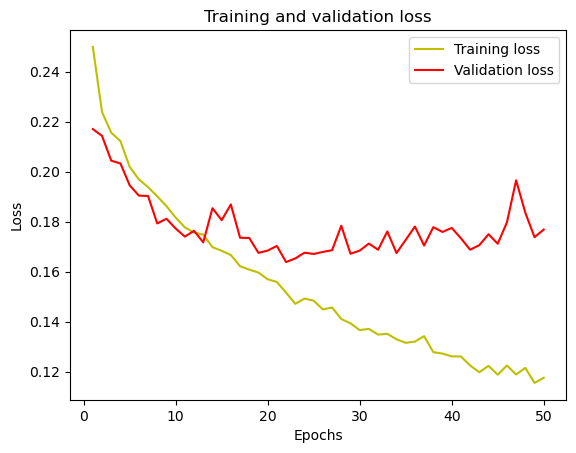

In [103]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



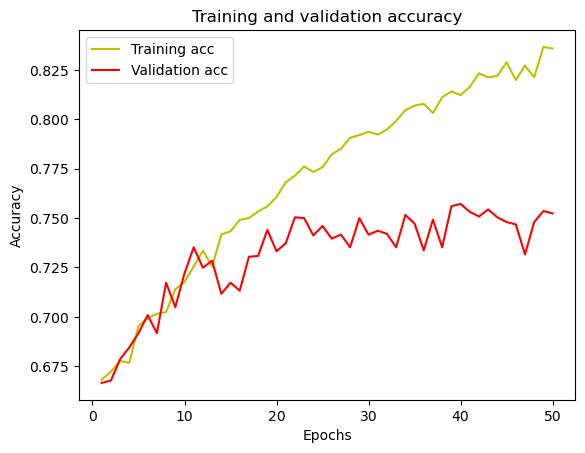

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [108]:
# Prediction on test data
y_pred = model.predict(x_test)

79/79 [==============================] - 1s 12ms/step


In [109]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 



79/79 [==============================] - 1s 12ms/step


In [111]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)


<Axes: >

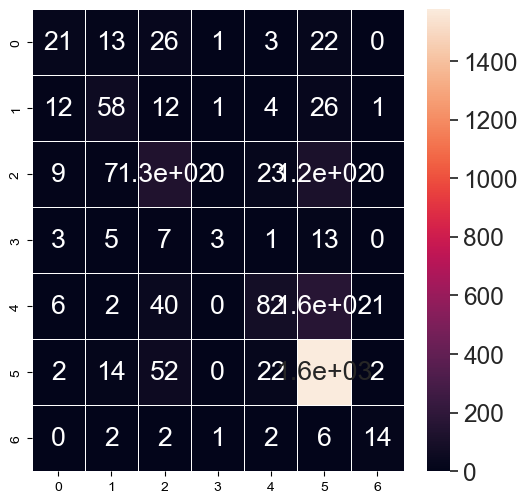

In [112]:

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

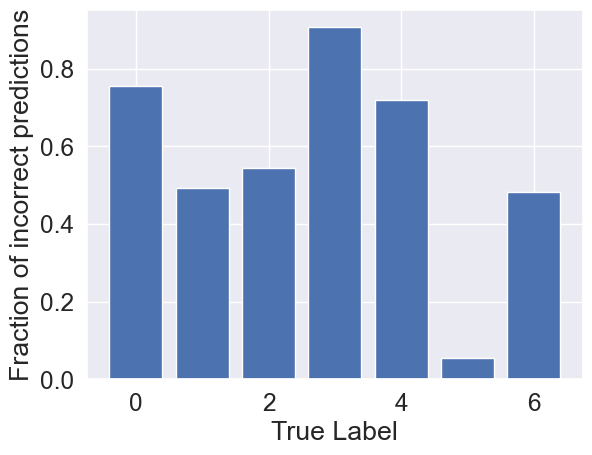

In [113]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')